In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
ori_df = pd.read_csv('../../traces/MSR-Cambridge2/CAMRESSDPA01-lvm0.csv', header=None)
ori_df.columns = ['Timestamp', 'Hostname', 'DiskNumber', 'Type', 'Offset', 'Size', 'ResponseTime']
ori_df['Timestamp'] = ori_df['Timestamp'].astype(np.int64)
ori_df = ori_df.sort_values(by='Timestamp')
ori_df.head()
#df.tail()

,Timestamp,Hostname,DiskNumber,Type,Offset,Size,ResponseTime
0,128166373321652068,src1,0,Write,3173167104,36864,3126
1,128166373321653856,src1,0,Write,3154128896,4096,1337
2,128166373321653876,src1,0,Write,3154132992,4096,1318
3,128166373371652876,src1,0,Write,3744964608,4096,1998
4,128166373421651545,src1,0,Write,3173203968,32768,3009


In [3]:
unified_df = ori_df
unified_df.head()

,Timestamp,Hostname,DiskNumber,Type,Offset,Size,ResponseTime
0,128166373321652068,src1,0,Write,3173167104,36864,3126
1,128166373321653856,src1,0,Write,3154128896,4096,1337
2,128166373321653876,src1,0,Write,3154132992,4096,1318
3,128166373371652876,src1,0,Write,3744964608,4096,1998
4,128166373421651545,src1,0,Write,3173203968,32768,3009


In [4]:
mod = 96767
unified_df['unified_size'] = unified_df['Offset']%mod

In [5]:
unified_df.head(10)

,Timestamp,Hostname,DiskNumber,Type,Offset,Size,ResponseTime,unified_size
0,128166373321652068,src1,0,Write,3173167104,36864,3126,80407
1,128166373321653856,src1,0,Write,3154128896,4096,1337,8531
2,128166373321653876,src1,0,Write,3154132992,4096,1318,12627
3,128166373371652876,src1,0,Write,3744964608,4096,1998,81708
4,128166373421651545,src1,0,Write,3173203968,32768,3009,20504
5,128166373421653201,src1,0,Write,3154124800,4096,1353,4435
6,128166373421653217,src1,0,Write,3154137088,4096,1336,16723
7,128166373443526257,src1,0,Write,190584221696,4096,3156,66924
8,128166373471650960,src1,0,Write,3173236736,36864,3273,53272
9,128166373471652888,src1,0,Write,3154132992,4096,1345,12627


In [6]:
# select partial of the dataframe

min_offset = 0 
max_offset = 3154128897

selected_df = unified_df[unified_df['Offset'] < max_offset]
selected_df = selected_df[unified_df['Offset'] > min_offset]


/home/ovs3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [7]:
selected_df.head(10)

,Timestamp,Hostname,DiskNumber,Type,Offset,Size,ResponseTime,unified_size
1,128166373321653856,src1,0,Write,3154128896,4096,1337,8531
5,128166373421653201,src1,0,Write,3154124800,4096,1353,4435
10,128166373471652934,src1,0,Write,3154128896,4096,1299,8531
13,128166373521652580,src1,0,Write,3154124800,4096,1333,4435
17,128166373571652279,src1,0,Write,3154128896,4096,1314,8531
21,128166373671651510,src1,0,Write,3154124800,4096,1443,4435
23,128166374771644542,src1,0,Write,3154128896,4096,1372,8531
28,128166374871643938,src1,0,Write,3154124800,4096,1335,4435
32,128166374971643338,src1,0,Write,3154128896,4096,1296,8531
34,128166375171641965,src1,0,Write,3154124800,4096,1388,4435


In [8]:
# This block change the file size 

selected_df['Size'] = selected_df['unified_size']

In [9]:
print(selected_df['Hostname'].value_counts())
print(selected_df['DiskNumber'].value_counts())
sel_req_num = selected_df['Timestamp'].count()
sel_req_num

src1    131579
Name: Hostname, dtype: int64
0    131579
Name: DiskNumber, dtype: int64


131579

In [10]:
total_size = selected_df.drop_duplicates(['Offset'])['Size'].sum()
total_size

4122844629

In [11]:
max_cache_size = 10000000000
cache_size_array = [max_cache_size*0.01, max_cache_size*0.05, max_cache_size*0.1, max_cache_size*0.5, max_cache_size]

In [12]:
# Take first 10% of the trace
sample_num = int(sel_req_num * 0.5)
df = selected_df.head(sample_num)

In [13]:
req_num = df['Timestamp'].count()
req_num

65789

In [14]:
total_size = df.drop_duplicates(['Offset'])['Size'].sum()
total_size

1653818767

In [15]:
workload_of_caches = [0, 0, 0, 0]
for row in df.drop_duplicates(['Offset']).itertuples():
    workload_of_caches[(getattr(row, 'Offset') // 10000 % 1000000) & 0b11111 % 4] += 1
workload_of_caches        # 检验哈希函数合理性

[8534, 8512, 8539, 8549]

In [17]:
def make_requests():
    for row in df.itertuples():
        yield getattr(row, 'Offset'), getattr(row, 'Size')

In [18]:
class Server:                                       # 服务器(cache)
    def __init__(self, space):
        self.space = space                          # cache大小
        self.remain = space                         # cache剩余空间
        self.cache = OrderedDict()                  # OrderDict() 模拟cache LRU方法
        self.hit_count = 0                          # 命中次数
        self.bite_hit_count = 0
        self.miss_count = 0                         # 未命中次数
        self.bite_miss_count = 0

    def _hit(self, fid, size):
        self.hit_count += 1
        self.bite_hit_count += size
        self.cache.move_to_end(fid)

    def _miss(self, fid, size):
        self.miss_count += 1
        self.bite_miss_count += size
        while self.remain < size:
            self.remain += self.cache.popitem(last=False)[-1]  # pop出第一个item
        self.cache[fid] = size
        self.remain -= size

    def handle(self, fid, size):                         # 处理一次请求
        if fid in self.cache.keys():
            self._hit(fid, size)
            #return 1
        else:
            self._miss(fid, size)
            #return 0

    def hit_rate(self):
        try:
            return self.hit_count / (self.hit_count + self.miss_count)
        except:
            return "Server has not been requested yet!"
    
    def bite_hit_rate(self):
        try:
            return self.bite_hit_count / (self.bite_hit_count + self.bite_miss_count)
        except:
            return "Server has not been requested yet!"

In [19]:
class Dispatcher:
    def __init__(self, file_number, cache_size, cache_number, simple=True):
        self.cache_number = cache_number
        self.big_cache = Server(cache_size * cache_number)
        self.small_caches = []
        for i in range(cache_number):
            server = Server(cache_size)
            self.small_caches.append(server)
        self.small_caches_heat = [0] * cache_number
        if simple:
            self.handle_requests = self.simple_hash
        else:
            self.handle_requests = self.load_balance
            self.file_mapper = {}
            for row in df.drop_duplicates(['Offset']).itertuples():
                fid = getattr(row,'Offset')
                self.file_mapper[fid] = (fid // 10000 % 1000000) & 0b11111 % cache_number
        
    def load_balance(self, fid, size):
        server = self.file_mapper[fid]
        if fid in self.small_caches[server].cache.keys():
            self.small_caches[server].handle(fid, size)
            self.small_caches_heat[self.file_mapper[fid]] += size
        else:
            server = self.small_caches_heat.index(min(self.small_caches_heat))
            self.small_caches[server].handle(fid, size)
            self.file_mapper[fid] = server
        self.big_cache.handle(fid, size)
        
    def simple_hash(self, fid, size):
        self.big_cache.handle(fid, size)
        self.small_caches[(fid // 10000 % 1000000) & 0b11111 % self.cache_number].handle(fid, size)

In [20]:
FILE_NUM = len(df['Offset'].value_counts())
CACHE_NUMBER = 4
print(FILE_NUM)
print(CACHE_NUMBER)

5345279
4


In [21]:
'''small_server_hit_rate = []
small_server_hit_number = []
small_server_hit_ratio = []
small_server_hit_ratio_syn = []
big_server_hit_rate = []
big_server_hit_number = []
big_server_hit_ratio = []
big_server_hit_ratio_syn = []

cache_size_array = []
for cache_size in range(total_size // 100, total_size // 10, total_size // 100):
    cache_size_array.append(cache_size / total_size)
    hash_dispatcher = Dispatcher(FILE_NUM, cache_size, CACHE_NUMBER)
    for fid, size in make_requests():
        hash_dispatcher.handle_requests(fid, size)
    small_server_hit_rate.append([i.hit_rate() for i in hash_dispatcher.small_caches])
    small_server_hit_number.append(sum([i.hit_count for i in hash_dispatcher.small_caches]))
    small_server_hit_ratio.append((sum([i.hit_count for i in hash_dispatcher.small_caches]))/req_num)
    big_server_hit_rate.append(hash_dispatcher.big_cache.hit_rate())
    big_server_hit_number.append(hash_dispatcher.big_cache.hit_count)
    big_server_hit_ratio.append((sum([i.hit_count for i in hash_dispatcher.small_caches]))/req_num)'''

'small_server_hit_rate = []\nsmall_server_hit_number = []\nsmall_server_hit_ratio = []\nsmall_server_hit_ratio_syn = []\nbig_server_hit_rate = []\nbig_server_hit_number = []\nbig_server_hit_ratio = []\nbig_server_hit_ratio_syn = []\n\ncache_size_array = []\nfor cache_size in range(total_size // 100, total_size // 10, total_size // 100):\n    cache_size_array.append(cache_size / total_size)\n    hash_dispatcher = Dispatcher(FILE_NUM, cache_size, CACHE_NUMBER)\n    for fid, size in make_requests():\n        hash_dispatcher.handle_requests(fid, size)\n    small_server_hit_rate.append([i.hit_rate() for i in hash_dispatcher.small_caches])\n    small_server_hit_number.append(sum([i.hit_count for i in hash_dispatcher.small_caches]))\n    small_server_hit_ratio.append((sum([i.hit_count for i in hash_dispatcher.small_caches]))/req_num)\n    big_server_hit_rate.append(hash_dispatcher.big_cache.hit_rate())\n    big_server_hit_number.append(hash_dispatcher.big_cache.hit_count)\n    big_server_hit_

In [22]:
'''plt.figure(figsize=(15,8))
plt.plot(cache_size_array, small_server_hit_number, color='red', label='little caches')
plt.plot(cache_size_array, big_server_hit_number, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit number")
plt.title("simple hash")
plt.legend()
#small_server_hit_ratio
df.tail()
#print(df['Hostname'].value_counts())
#df['Hostname'].value_counts()
df['Hostname'].count()'''

'plt.figure(figsize=(15,8))\nplt.plot(cache_size_array, small_server_hit_number, color=\'red\', label=\'little caches\')\nplt.plot(cache_size_array, big_server_hit_number, color=\'black\', label=\'big cache\')\nplt.xlabel("little cache size / file pool total size")\nplt.ylabel("hit number")\nplt.title("simple hash")\nplt.legend()\n#small_server_hit_ratio\ndf.tail()\n#print(df[\'Hostname\'].value_counts())\n#df[\'Hostname\'].value_counts()\ndf[\'Hostname\'].count()'

In [23]:
'''plt.figure(figsize=(15,8))
plt.plot(cache_size_array, small_server_hit_ratio, color='red', label='little caches')
plt.plot(cache_size_array, big_server_hit_ratio, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit ratio")
plt.title("simple hash")
plt.legend()'''

'plt.figure(figsize=(15,8))\nplt.plot(cache_size_array, small_server_hit_ratio, color=\'red\', label=\'little caches\')\nplt.plot(cache_size_array, big_server_hit_ratio, color=\'black\', label=\'big cache\')\nplt.xlabel("little cache size / file pool total size")\nplt.ylabel("hit ratio")\nplt.title("simple hash")\nplt.legend()'

In [24]:
'''colors = ['green', 'yellow', 'blue', 'red']
plt.figure(figsize=(15,8))
for i in range(CACHE_NUMBER):
    plt.plot(cache_size_array, [j[i] for j in small_server_hit_rate], color=colors[i], label='little cache ' + str(i + 1))
plt.plot(cache_size_array, big_server_hit_rate, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit rate")
plt.title("simple hash")
plt.legend()'''

'colors = [\'green\', \'yellow\', \'blue\', \'red\']\nplt.figure(figsize=(15,8))\nfor i in range(CACHE_NUMBER):\n    plt.plot(cache_size_array, [j[i] for j in small_server_hit_rate], color=colors[i], label=\'little cache \' + str(i + 1))\nplt.plot(cache_size_array, big_server_hit_rate, color=\'black\', label=\'big cache\')\nplt.xlabel("little cache size / file pool total size")\nplt.ylabel("hit rate")\nplt.title("simple hash")\nplt.legend()'

In [25]:
small_server_hit_rate_ = []
small_server_hit_number_ = []
small_server_hit_ratio_ = []
small_server_hit_number_syn_ = []
small_server_hit_ratio_syn_ = []
big_server_hit_rate_ = []
big_server_hit_number_ = []
big_server_hit_ratio_ = []
big_server_hit_number_syn_ = []
big_server_hit_ratio_syn_ = []

#small_server_hit_seq = []
#big_server_hit_seq = []

cache_size_array_ = []
#for cache_size in range(total_size // 100, total_size // 10, total_size // 100):
#    cache_size_array_.append(cache_size / total_size)
for cache_size in cache_size_array:
    cache_size_array_.append(cache_size)
    hash_dispatcher = Dispatcher(FILE_NUM, cache_size, CACHE_NUMBER, False)
    cur_req = 0
    sub_big_server_hit_ratio_syn_ = []
    sub_small_server_hit_ratio_syn_ = []
    
    sub_big_server_hit_number_syn_ = []
    sub_small_server_hit_number_syn_ = []
    
    for fid, size in make_requests():
        hash_dispatcher.handle_requests(fid, size)
        
        
        cur_req += 1
        
        sub_big_server_hit_ratio_syn_.append(hash_dispatcher.big_cache.hit_count/cur_req)
        sub_small_server_hit_ratio_syn_.append(sum([i.hit_count for i in hash_dispatcher.small_caches])/cur_req)
        
        sub_big_server_hit_number_syn_.append(hash_dispatcher.big_cache.hit_count)
        sub_small_server_hit_number_syn_.append(sum([i.hit_count for i in hash_dispatcher.small_caches]))
        
    big_server_hit_ratio_syn_.append(sub_big_server_hit_ratio_syn_)
    small_server_hit_ratio_syn_.append(sub_small_server_hit_ratio_syn_)
    
    big_server_hit_number_syn_.append(sub_big_server_hit_number_syn_)
    small_server_hit_number_syn_.append(sub_small_server_hit_number_syn_)
        
    small_server_hit_rate_.append([i.hit_rate() for i in hash_dispatcher.small_caches])
    small_server_hit_number_.append(sum([i.hit_count for i in hash_dispatcher.small_caches]))
    small_server_hit_ratio_.append(sum([i.hit_count for i in hash_dispatcher.small_caches])/req_num)
    big_server_hit_rate_.append(hash_dispatcher.big_cache.hit_rate())
    big_server_hit_number_.append(hash_dispatcher.big_cache.hit_count)
    big_server_hit_ratio_.append(hash_dispatcher.big_cache.hit_count/req_num)

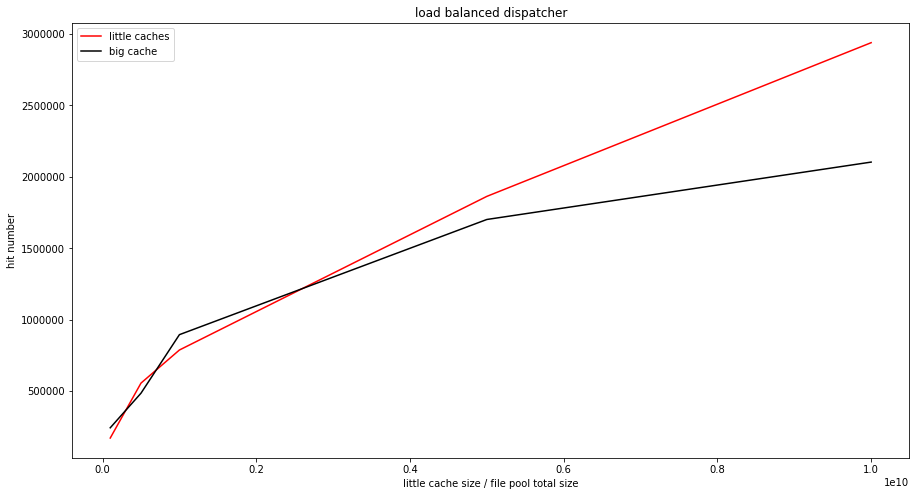

In [26]:
plt.figure(figsize=(15,8))
plt.plot(cache_size_array_, small_server_hit_number_, color='red', label='little caches')
plt.plot(cache_size_array_, big_server_hit_number_, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit number")
plt.title("load balanced dispatcher")
plt.legend()

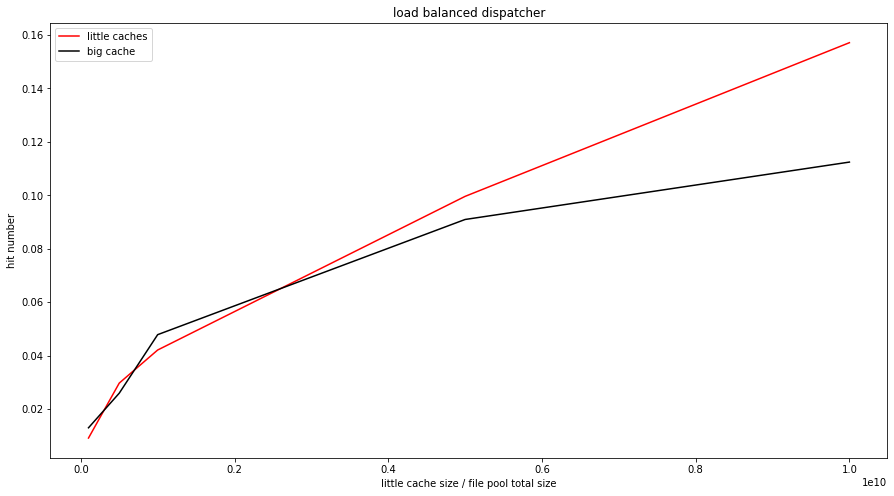

In [27]:
plt.figure(figsize=(15,8))
plt.plot(cache_size_array_, small_server_hit_ratio_, color='red', label='little caches')
plt.plot(cache_size_array_, big_server_hit_ratio_, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit number")
plt.title("load balanced dispatcher")
plt.legend()

/home/ovs3/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/ovs3/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


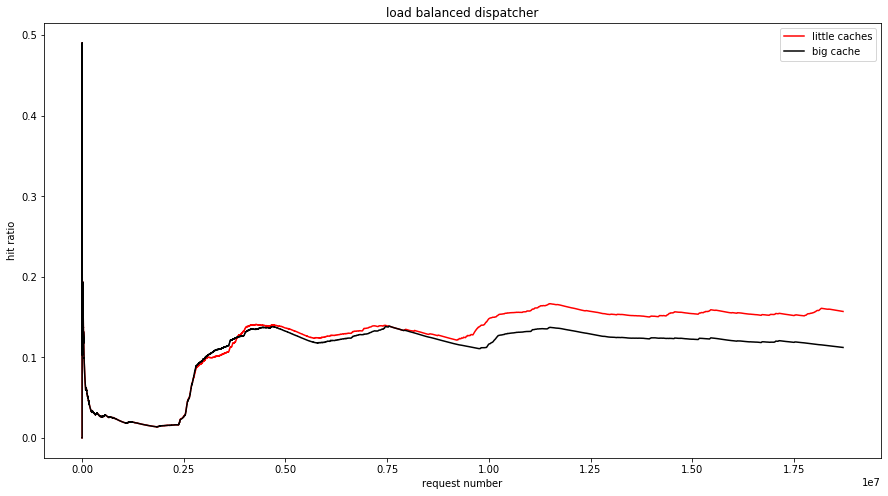

In [28]:
plt.figure(figsize=(15,8))
plt.plot(range(len(small_server_hit_ratio_syn_[4])), small_server_hit_ratio_syn_[4], color='red', label='little caches')
plt.plot(range(len(big_server_hit_ratio_syn_[4])), big_server_hit_ratio_syn_[4], color='black', label='big cache')
plt.xlabel("request number")
plt.ylabel("hit ratio")
plt.title("load balanced dispatcher")
plt.legend()

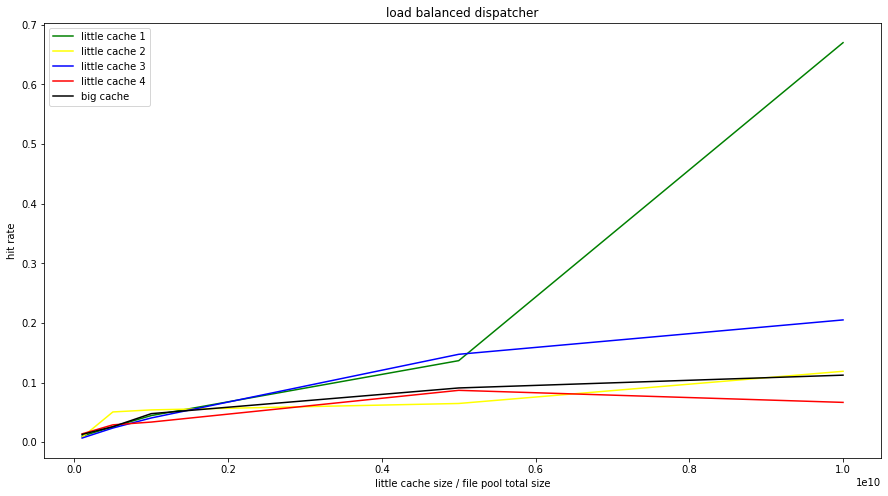

In [29]:
colors = ['green', 'yellow', 'blue', 'red']
plt.figure(figsize=(15,8))
for i in range(CACHE_NUMBER):
    plt.plot(cache_size_array_, [j[i] for j in small_server_hit_rate_], color=colors[i], label='little cache ' + str(i + 1))
plt.plot(cache_size_array_, big_server_hit_rate_, color='black', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit rate")
plt.title("load balanced dispatcher")
plt.legend()

In [30]:
x = df['Offset'].value_counts().values

No handles with labels found to put in legend.


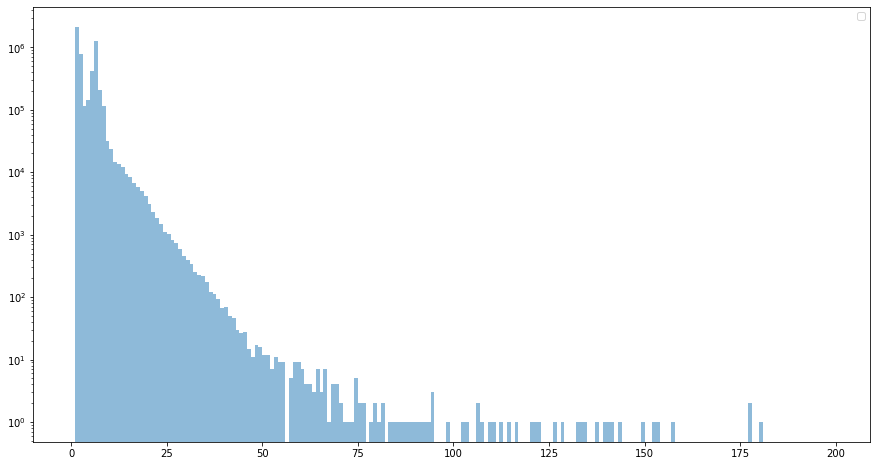

In [31]:
plt.figure(figsize=(15,8))
bins = np.arange(0, 200, 1)
#plt.hist(x[2:], bins, alpha=0.5)
plt.hist(x[2:], bins, alpha=0.5, log = True)
#plt.xlim(0, 1000)
#plt.yscale('log')
plt.legend()

No handles with labels found to put in legend.


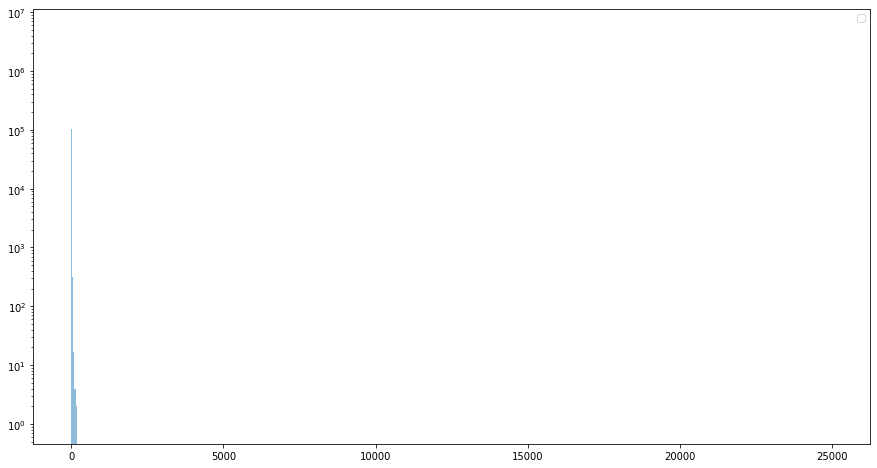

In [32]:
plt.figure(figsize=(15,8))
bins = np.arange(0, 25000, 10)
#plt.hist(x[2:], bins, alpha=0.5)
plt.hist(x[2:], bins, alpha=0.5, log = True)
#plt.xlim(0, 1000)
#plt.yscale('log')
plt.legend()

In [33]:
small_server_hit_seq = []
big_server_hit_seq = []

ini_hit = 0

for i in range(len(small_server_hit_number_syn_[4])):
    req = small_server_hit_number_[4][i]
    if i == 0:
        prevreq = ini_hit
    else:
        prevreq = small_server_hit_number_[4][i-1]
    small_server_hit_seq.append(req-prevreq)

for i in range(len(big_server_hit_number_syn_[4])):
    req = big_server_hit_number_[4][i]
    if i == 0:
        prevreq = ini_hit
    else:
        prevreq = big_server_hit_number_[4][i-1]
    big_server_hit_seq.append(req-prevreq)
        
    

TypeError: 'int' object is not subscriptable

In [34]:
print(len(sub_small_server_hit_number_syn_))

18707806


In [35]:
small_server_hit_seq = []
big_server_hit_seq = []

ini_hit = 0

for i in range(len(sub_small_server_hit_number_syn_)):
    req = sub_small_server_hit_number_syn_[i]
    if i == 0:
        prevreq = ini_hit
    else:
        prevreq = sub_small_server_hit_number_syn_[i-1]
    small_server_hit_seq.append(req-prevreq)

for i in range(len(sub_big_server_hit_number_syn_)):
    req = sub_big_server_hit_number_syn_[i]
    if i == 0:
        prevreq = ini_hit
    else:
        prevreq = sub_big_server_hit_number_syn_[i-1]
    big_server_hit_seq.append(req-prevreq)

In [36]:
diff_small_and_big = []

for i in range(len(small_server_hit_seq)):
    if (small_server_hit_seq[i] > big_server_hit_seq[i]):
        diff_small_and_big.append(i)

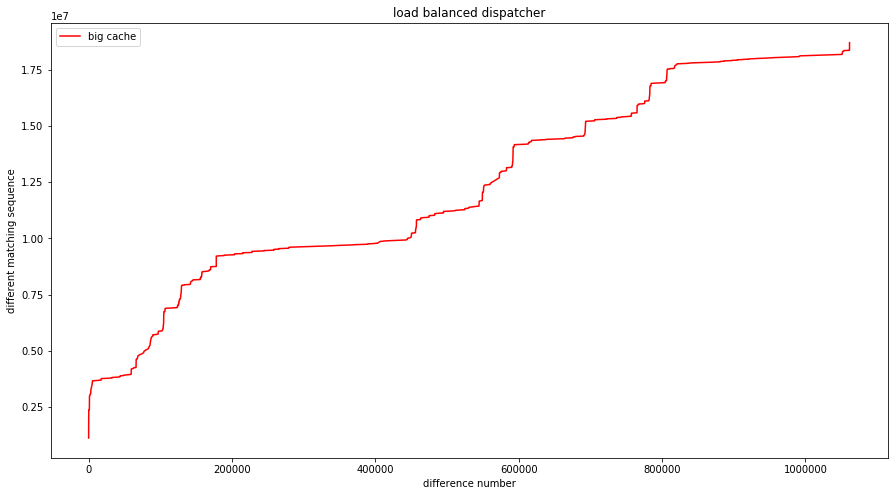

In [37]:
plt.figure(figsize=(15,8))
#plt.plot(range(len(small_server_hit_ratio_syn_[4])), small_server_hit_ratio_syn_[4], color='red', label='little caches')
plt.plot(range(len(diff_small_and_big)), diff_small_and_big, color='red', label='big cache')
plt.xlabel("difference number")
plt.ylabel("different matching sequence")
plt.title("load balanced dispatcher")
plt.legend()

In [38]:
diff_small_and_big_seq = []

for i in range(len(small_server_hit_seq)):
    diff_small_and_big_seq.append(small_server_hit_seq[i] - big_server_hit_seq[i])
    
print(len(diff_small_and_big_seq))

18707806


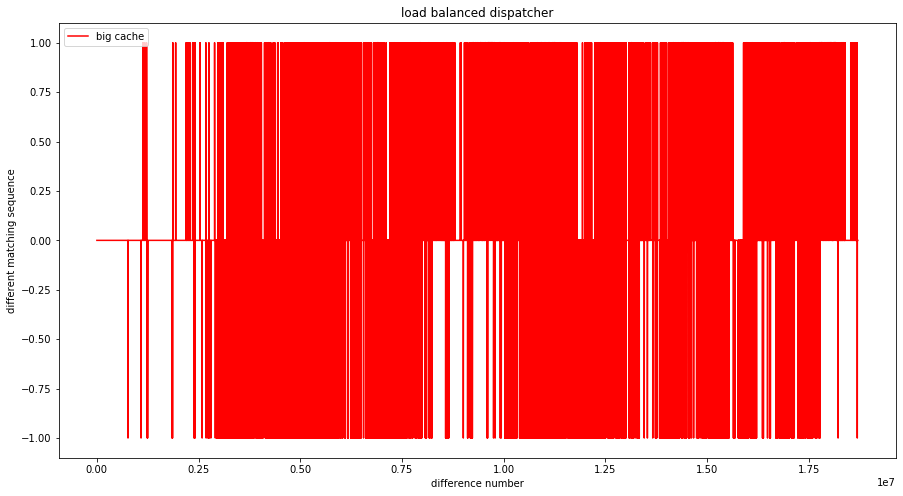

In [39]:
plt.figure(figsize=(15,8))
#plt.plot(range(len(small_server_hit_ratio_syn_[4])), small_server_hit_ratio_syn_[4], color='red', label='little caches')
plt.plot(range(len(diff_small_and_big_seq)), diff_small_and_big_seq, color='red', label='big cache')
plt.xlabel("difference number")
plt.ylabel("different matching sequence")
plt.title("load balanced dispatcher")
plt.legend()

In [40]:
diff_small_and_big_seq_accumulation = []

acc = 0

for i in range(len(small_server_hit_seq)):
    #diff_small_and_big_seq.append(small_server_hit_seq[i] - big_server_hit_seq[i])
    acc = small_server_hit_seq[i] - big_server_hit_seq[i] + acc
    diff_small_and_big_seq_accumulation.append(acc)
    
#print(len(diff_small_and_big_seq))

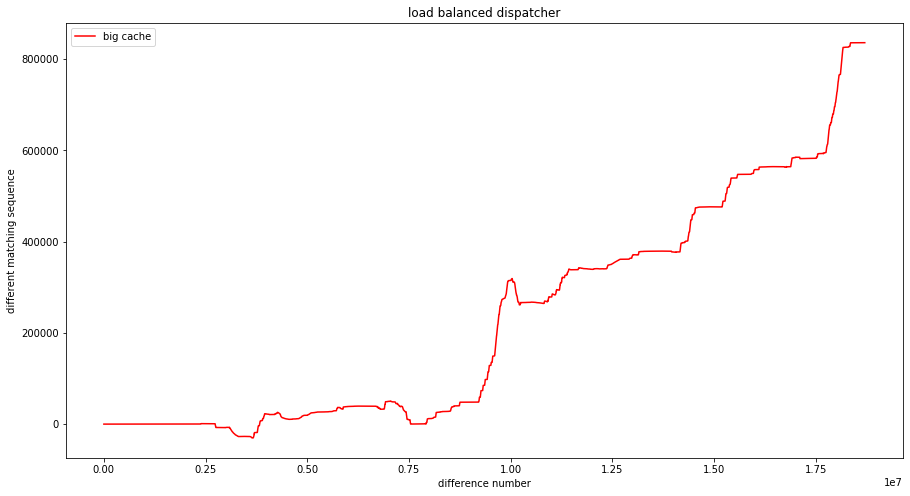

In [41]:
plt.figure(figsize=(15,8))
#plt.plot(range(len(small_server_hit_ratio_syn_[4])), small_server_hit_ratio_syn_[4], color='red', label='little caches')
plt.plot(range(len(diff_small_and_big_seq_accumulation)), diff_small_and_big_seq_accumulation, color='red', label='big cache')
plt.xlabel("difference number")
plt.ylabel("different matching sequence")
plt.title("load balanced dispatcher")
plt.legend()

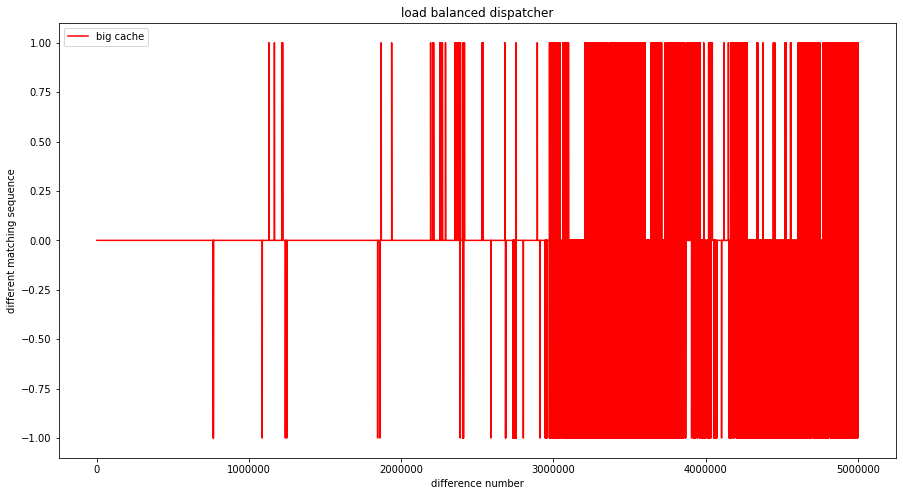

In [42]:
# Partial analysis
diff_small_and_big_seq_head = diff_small_and_big_seq[0:5000000]

plt.figure(figsize=(15,8))
#plt.plot(range(len(small_server_hit_ratio_syn_[4])), small_server_hit_ratio_syn_[4], color='red', label='little caches')
plt.plot(range(len(diff_small_and_big_seq_head)), diff_small_and_big_seq_head, color='red', label='big cache')
plt.xlabel("difference number")
plt.ylabel("different matching sequence")
plt.title("load balanced dispatcher")
plt.legend()

In [43]:
print(len(diff_small_and_big))

1061457


In [44]:
diff_small_and_big[23]

2353736

In [45]:
for i in range(20):
    print(small_server_hit_seq[i])

0
0
0
0
0
0
0
0
0
1
1
0
1
1
0
0
1
1
0
0


In [46]:
for i in range(20):
    print(diff_small_and_big[i])

1130516
1166528
1215371
1220712
1868475
1937056
2193001
2208086
2208092
2208093
2208098
2212967
2212969
2212975
2255924
2255929
2256793
2269564
2270318
2290926


In [47]:
for i in range(20):
    print(diff_small_and_big[len(diff_small_and_big)-i-1])

18694584
18691650
18685887
18678182
18660136
18654440
18651565
18642715
18623887
18600810
18583559
18574940
18560564
18534570
18396244
18396143
18392112
18387740
18387485
18387368
